In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../')
#from pn2v import *
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from lib import histNoiseModel
from lib.utils import plotProbabilityDistribution
import os
import urllib
import zipfile
from pathlib import Path

from pystackreg import StackReg
from skimage.transform import warp,AffineTransform

In [2]:
# old way (n2v on "Single")
dir = r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\inference\N2V"
folder_list = [
    "Vim_fixed_OnInpSnr3_mseNoClipNeg",
]

    # "Vim_fixed_OnInpSnr0_mseNoClipNeg",
    # "Vim_fixed_OnInpSnr1_mseNoClipNeg",
    # "Vim_fixed_OnInpSnr2_mseNoClipNeg",
signal = []
observation =[]
for folder in folder_list:
    data_path = os.path.join(dir,folder)
    data_list = os.listdir(data_path)
    for file in data_list:
        im = imread(os.path.join(data_path,file))
        observation.append(im[0])
        signal.append(im[1])

# Stack to numpy array
signal = np.stack(signal)
observation = np.stack(observation)

print(signal.shape,observation.shape)
print("Signal:", np.mean(signal),np.std(signal),np.min(signal),np.max(signal))
print("Observation:", np.mean(observation),np.std(observation),np.min(observation),np.max(observation))


# signal_norm = (signal - np.mean(signal)) / np.std(signal)
# observation_norm = (observation - np.mean(observation)) / np.std(observation)
# print("After normalization:")
# print("Signal:", np.mean(signal_norm),np.std(signal_norm),np.min(signal_norm),np.max(signal_norm))
# print("Observation:", np.mean(observation_norm),np.std(observation_norm),np.min(observation_norm),np.max(observation_norm))


(25, 1416, 1392) (25, 1416, 1392)
Signal: 15.043884 29.024906 -85.29843 1305.8188
Observation: 5.5662966 52.40582 -619.28766 1640.4772


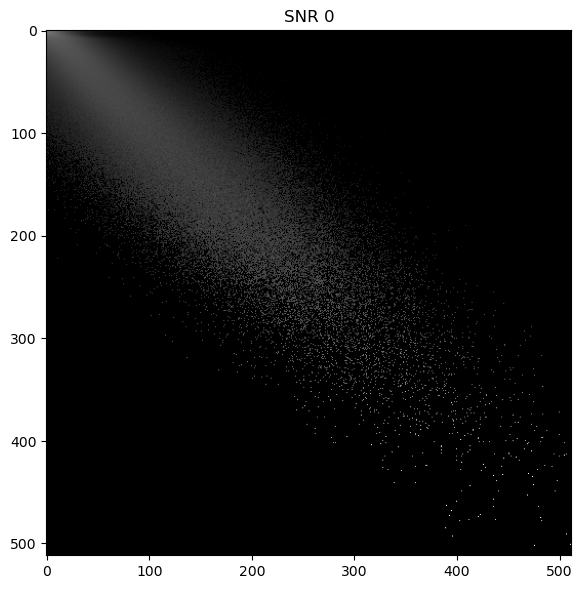

In [5]:
# Individual Noise models
minVal = -3
maxVal = 1300
pwr = 0.3
n_snr = 1
n_impersnr = 25
assert n_impersnr * n_snr == signal.shape[0]

plt.figure(figsize=(15,15))
for i in range(0,n_snr):
    histogram = histNoiseModel.createHistogram(512, minVal, maxVal, observation[i*n_impersnr:(i+1)*n_impersnr+1],signal[i*n_impersnr:(i+1)*n_impersnr+1])
    plt.subplot(2,2,i+1)
    plt.title(f"SNR {i}")
    plt.imshow(histogram[0]**pwr,cmap='gray')


plt.show()

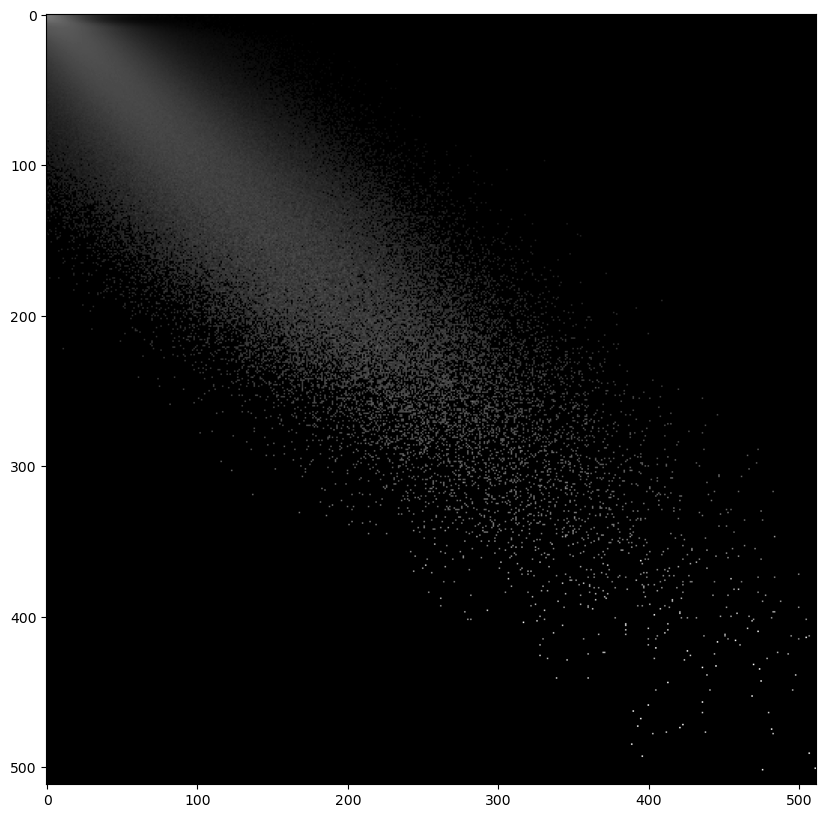

In [6]:
# Global Noise model

histogram = histNoiseModel.createHistogram(512, minVal, maxVal, observation,signal)

plt.figure(figsize=(10,10))
plt.imshow(histogram[0]**pwr,cmap='gray')
plt.show()

In [7]:
# Training GMM noise model
noiseModelsDir = r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\noise_models"
nameGMMNoiseModel = "GMM_Noise3_bootstrapped_Clip-3"
n_gaussian = 3# Number of gaussians to use for Gaussian Mixture Model
n_coeff = 4# No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.
fullnameGMMNoiseModel = f"/{nameGMMNoiseModel}_nGauss{n_gaussian}_nCoeff{n_coeff}"


gaussianMixtureNoiseModel = GaussianMixtureNoiseModel(min_signal = minVal,
                                                    max_signal = maxVal,
                                                    path=str(noiseModelsDir), weight = None, 
                                                    n_gaussian = n_gaussian,
                                                    n_coeff = n_coeff,
                                                    min_sigma = 5, 
                                                    device = device)

gaussianMixtureNoiseModel.train(signal, observation, batchSize = 250000, n_epochs = 1000, learning_rate=0.1, name = fullnameGMMNoiseModel)

Starting with loss = 16.597658157348633
0 16.597658157348633
Epoch 1: saved with loss 16.258224487304688
Epoch 2: saved with loss 15.949074745178223
Epoch 3: saved with loss 15.629514694213867
Epoch 4: saved with loss 15.309388160705566
Epoch 5: saved with loss 14.9533052444458
Epoch 6: saved with loss 14.632340431213379
Epoch 7: saved with loss 14.251066207885742
Epoch 8: saved with loss 13.870319366455078
Epoch 9: saved with loss 13.515823364257812
Epoch 10: saved with loss 13.133689880371094
Epoch 11: saved with loss 12.741049766540527
Epoch 12: saved with loss 12.33242130279541
Epoch 13: saved with loss 11.980329513549805
Epoch 14: saved with loss 11.606900215148926
Epoch 15: saved with loss 11.173972129821777
Epoch 16: saved with loss 10.774456024169922
Epoch 17: saved with loss 10.40819263458252
Epoch 18: saved with loss 10.034025192260742
Epoch 19: saved with loss 9.640606880187988
Epoch 20: saved with loss 9.297325134277344
Epoch 21: saved with loss 8.929163932800293
Epoch 22: 

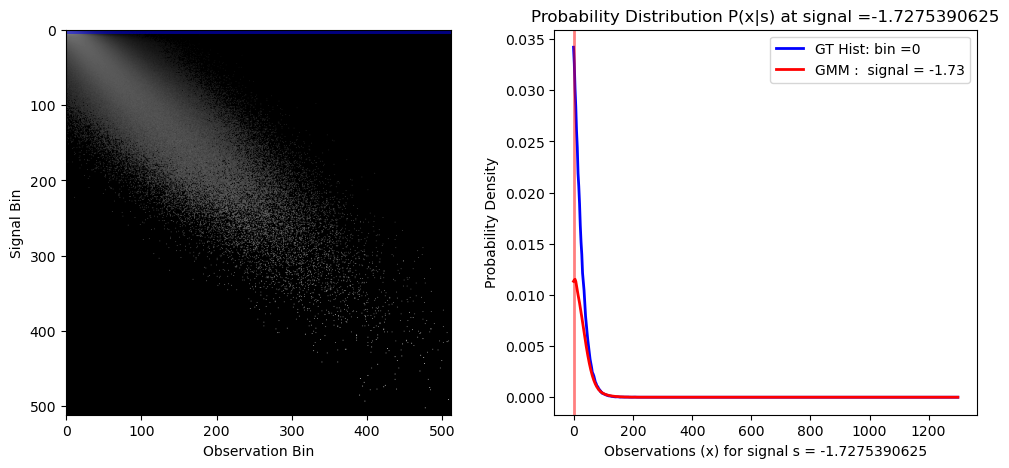

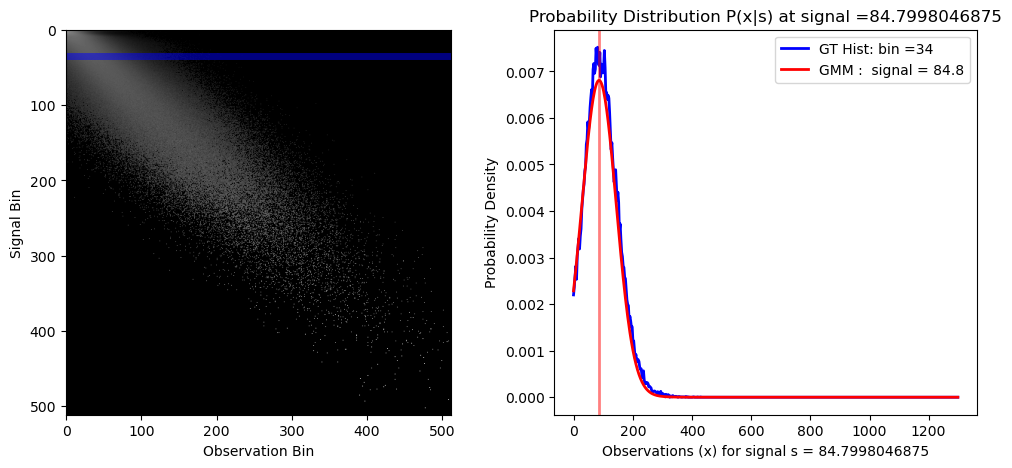

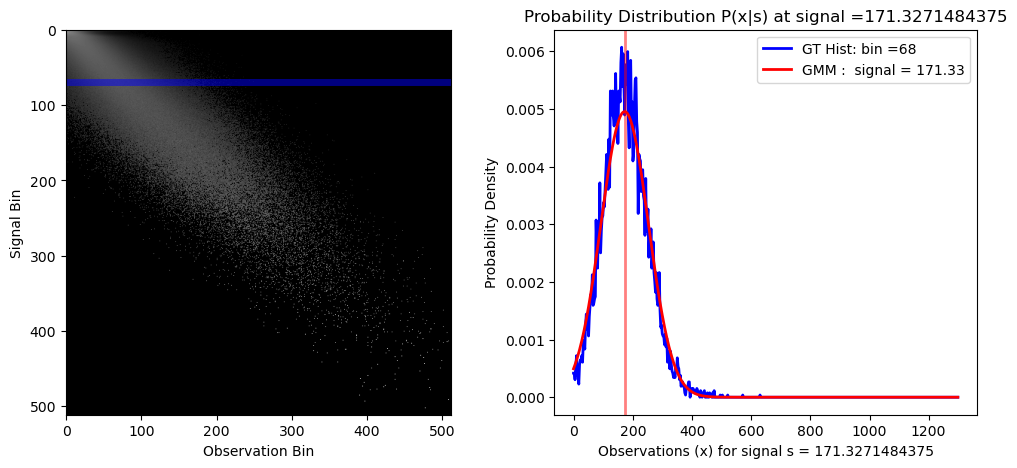

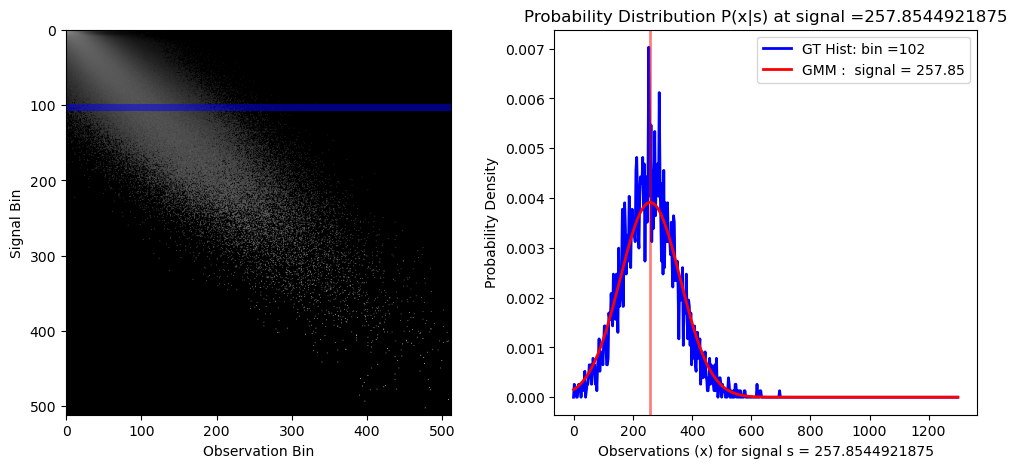

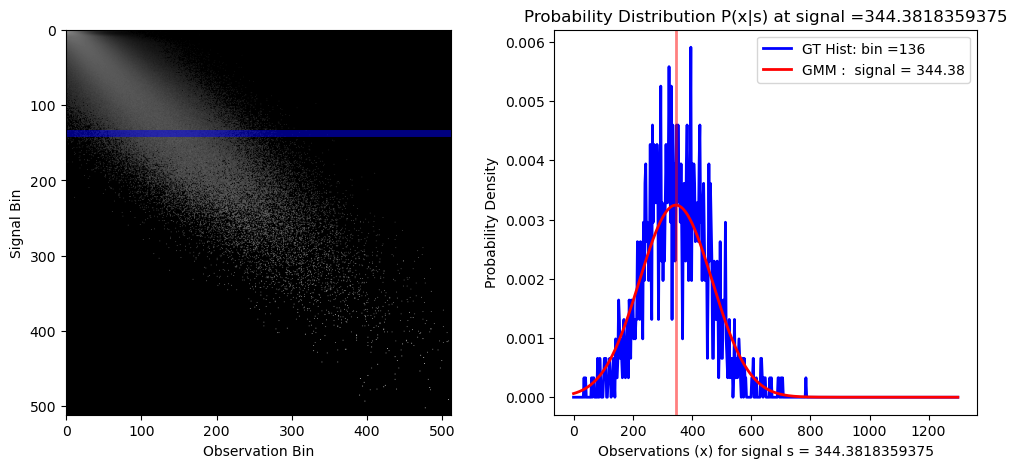

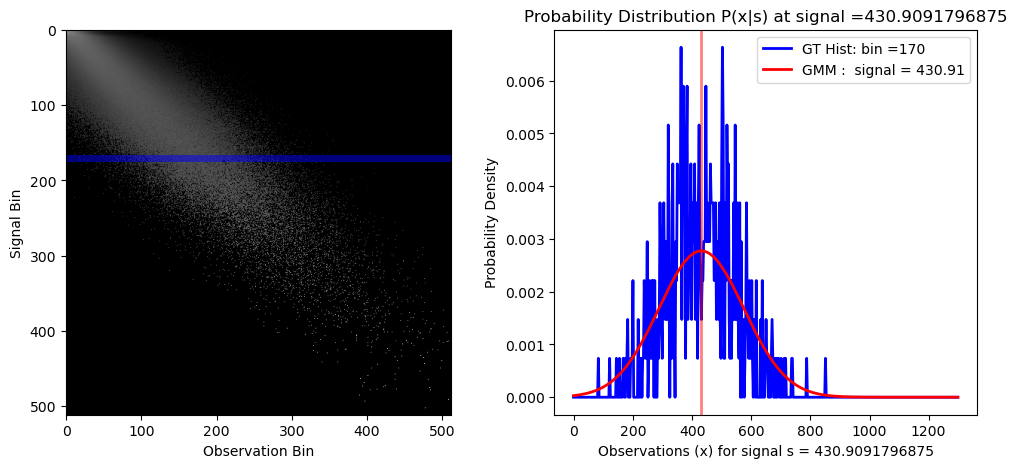

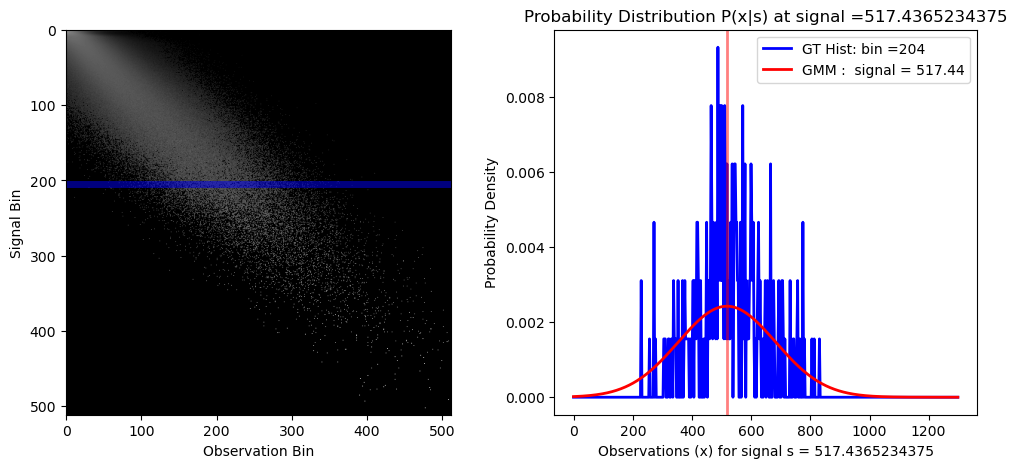

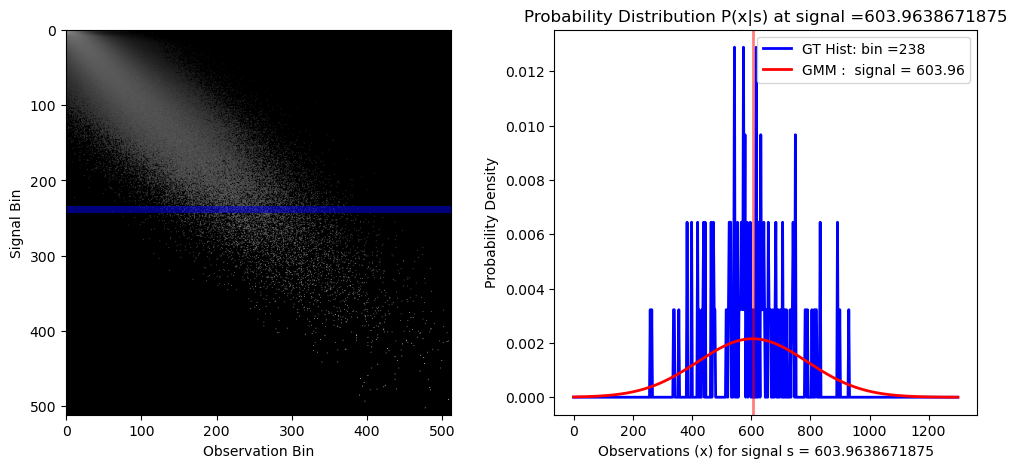

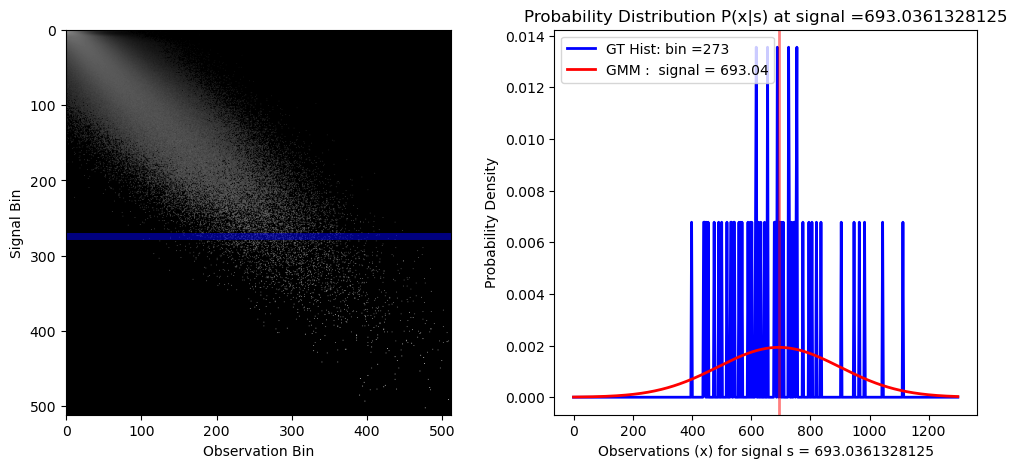

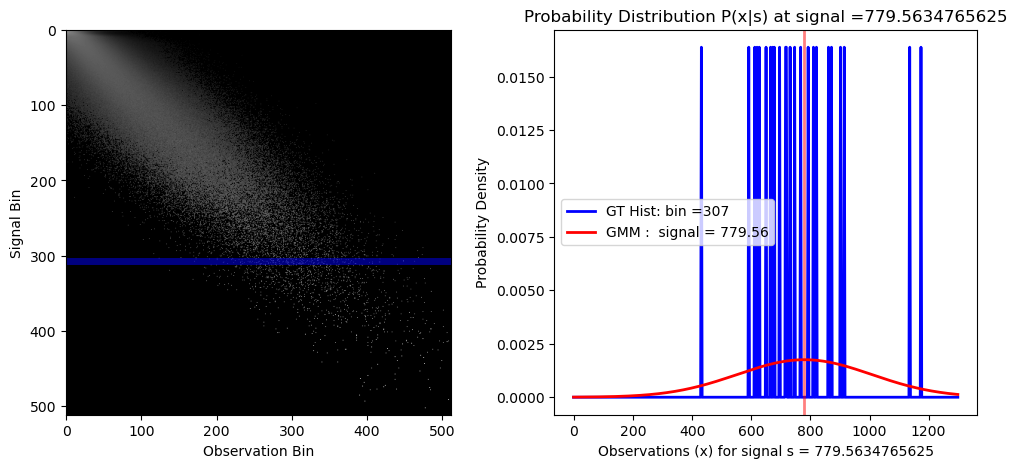

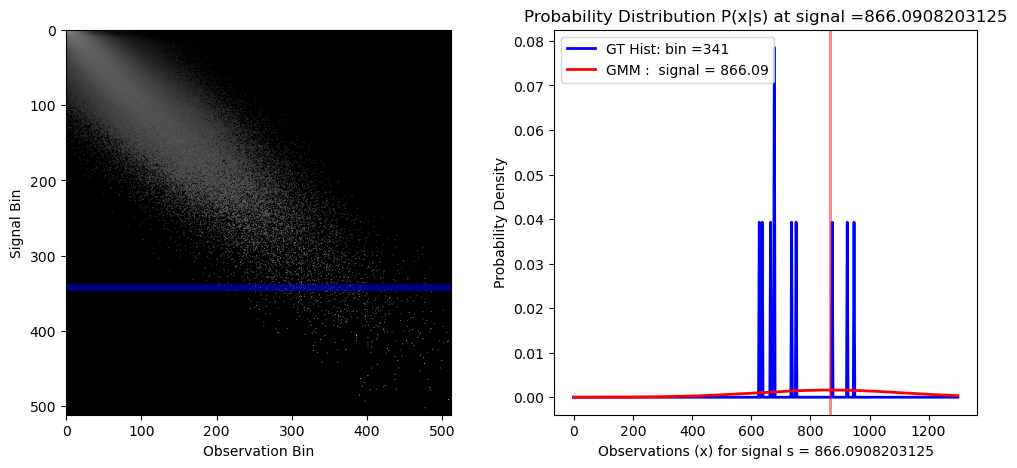

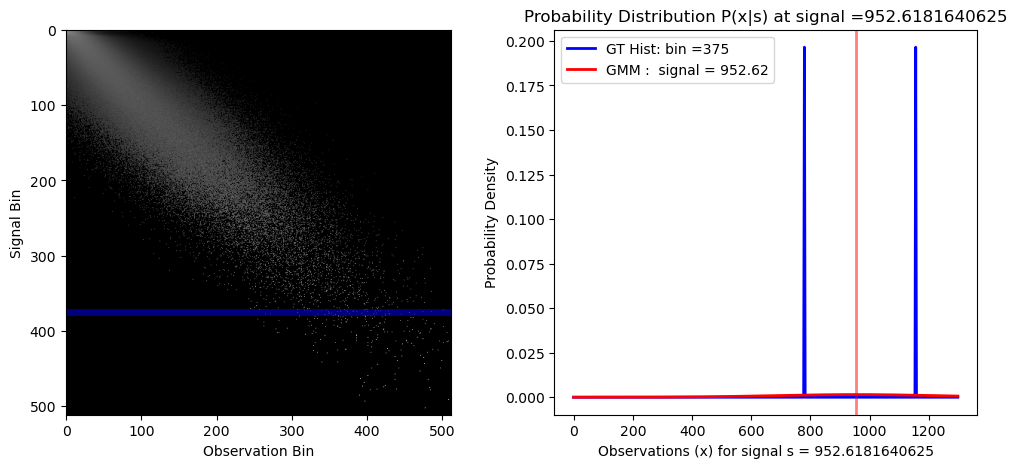

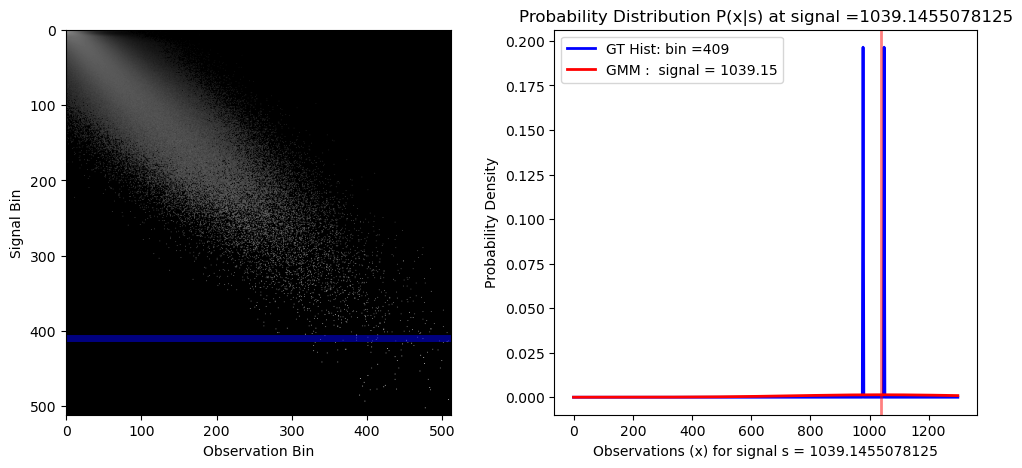

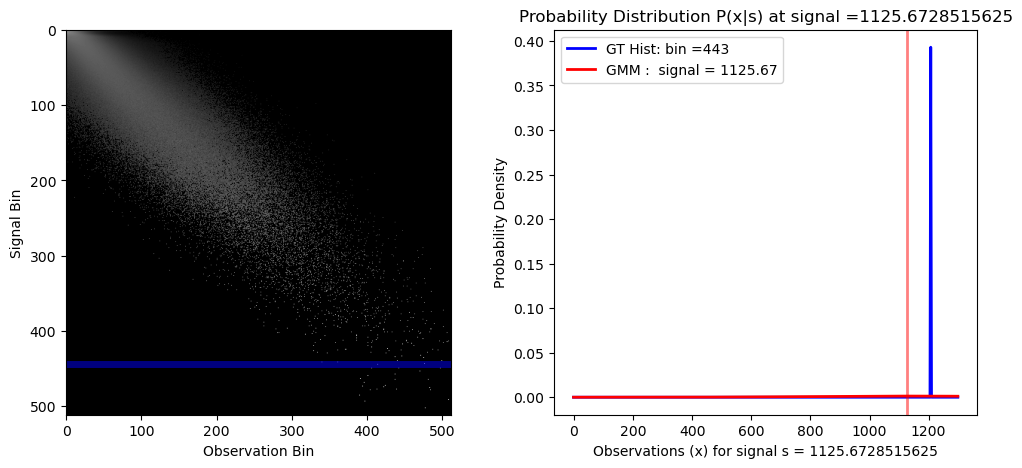

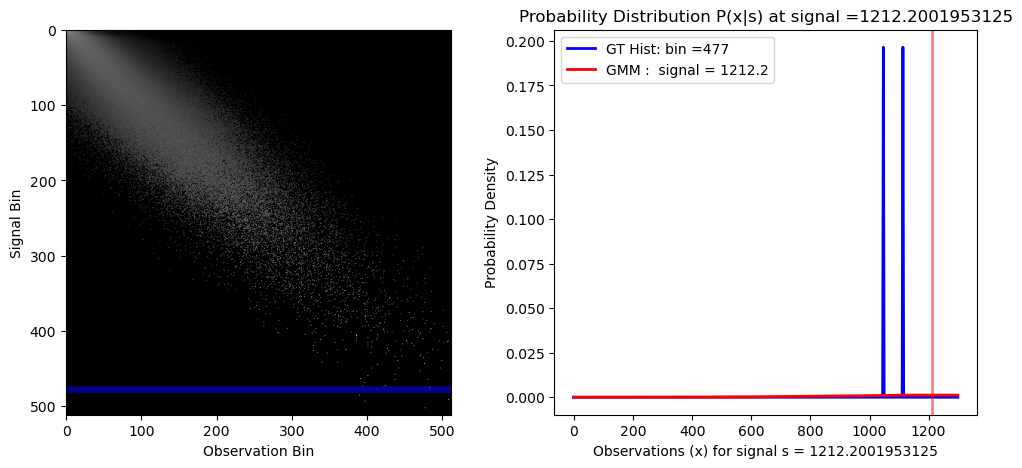

In [8]:
# Check GMM perf
GMMname = fullnameGMMNoiseModel[1::]+".npz" # to check current one
# GMMname = r"final_noReg/GMM_Noise0_SigN2V_Clip-3.npz"# to check existing one

n_points = 15
signalBinIndex_list = (np.linspace(0,n_points-1,n_points)*512//n_points).astype(int)
GMMmodel_prm = np.load(os.path.join(noiseModelsDir,GMMname))
GMMmodel = GaussianMixtureNoiseModel(params = GMMmodel_prm, device = device) 
for binidx in signalBinIndex_list:
    plotProbabilityDistribution(signalBinIndex=binidx, histogram=histogram[0], gaussianMixtureNoiseModel=GMMmodel, min_signal=minVal, max_signal=maxVal, n_bin=512, device=device)